# 分析方法
## 正态分布
对9只大猩猩称重得到的样本均值$\bar{x}=90$kg，样本标准差S=7.5kg。如果用$\bar{x}$估计总体均值，那么这一估计值的标准误差是多少？

如果一个数值X，符合参数为$\mu$和$\sigma$的正态分布，则可记为：

$X\sim N(\mu,\sigma^2)$

X'=aX+b

$X'\sim N(a\mu,a^2\sigma^2)$(1)

Z=X+Y,$X\sim N(\mu_X,\sigma_X^2),Y\sim N(\mu_Y,\sigma_Y^2)$

$Z\sim N(\mu_X+\mu_Y,\sigma_X^2+\sigma_Y^2)$(2)

如果从X中抽取n个值求和：

$Z\sim N(n\mu_X,n\sigma_X^2)$(3)

假设大猩猩体重X大致符合正态分布：$X\sim N(\mu,\sigma^2)$

如果测量n只大猩猩的体重，那么由公式(3)可知，体重之和Y的分布为：$Y \sim N(n\mu, n\sigma^2)$

将公式(1)中的a替换为1/n，即得到Y除以n所得的样本均值Z的分布：$Z \sim N(\mu, \sigma^2/n)$

Z的分布就是$\bar{x}$的抽样分布。Z的均值为$\mu$，说明$\bar{x}$是$\mu$的无偏估计。抽样分布的方差为$\sigma^2/n$。因此，抽样分布的标准差，即估计值的标准误差，为$\sigma/\sqrt{n}$。大猩猩示例中，$\sigma$为7.5kg，n为9，因此标准误差为2.5kg。这与第8章使用模拟方法得到结果一致。

In [2]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg

In [3]:
import math

class Normal(object):
    """Represents a Normal distribution"""

    def __init__(self, mu, sigma2, label=''):
        """Initializes.

        mu: mean
        sigma2: variance
        """
        self.mu = mu
        self.sigma2 = sigma2
        self.label = label

    def __str__(self):
        """Returns a string representation."""
        return 'N(%g, %g)' % (self.mu, self.sigma2)

    @property
    def sigma(self):
        """Returns the standard deviation."""
        return math.sqrt(self.sigma2)

    def __add__(self, other):
        """Adds a number or other Normal.

        other: number or Normal

        returns: new Normal
        """
        if isinstance(other, Normal):
            return Normal(self.mu + other.mu, self.sigma2 + other.sigma2)
        else:
            return Normal(self.mu + other, self.sigma2)

    __radd__ = __add__

    def __sub__(self, other):
        """Subtracts a number or other Normal.

        other: number or Normal

        returns: new Normal
        """
        if isinstance(other, Normal):
            return Normal(self.mu - other.mu, self.sigma2 + other.sigma2)
        else:
            return Normal(self.mu - other, self.sigma2)

    __rsub__ = __sub__

    def __mul__(self, factor):
        """Multiplies by a scalar.

        factor: number

        returns: new Normal
        """
        return Normal(factor * self.mu, factor**2 * self.sigma2)

    __rmul__ = __mul__

    def __div__(self, divisor):
        """Divides by a scalar.

        divisor: number

        returns: new Normal
        """
        return 1.0 / divisor * self

    __truediv__ = __div__

    def Sum(self, n):
        """Returns the distribution of the sum of n values.

        n: int

        returns: new Normal
        """
        return Normal(n * self.mu, n * self.sigma2)

    def Render(self):
        """Returns pair of xs, ys suitable for plotting.
        """
        mean, std = self.mu, self.sigma
        low, high = mean - 3 * std, mean + 3 * std
        xs, ys = thinkstats2.RenderNormalCdf(mean, std, low, high)
        return xs, ys

    def Prob(self, x):
        """Cumulative probability of x.

        x: numeric
        """
        return thinkstats2.EvalNormalCdf(x, self.mu, self.sigma)

    def Percentile(self, p):
        """Inverse CDF of p.

        p: percentile rank 0-100
        """
        return thinkstats2.EvalNormalCdfInverse(p/100, self.mu, self.sigma)
print('Gorilla example')
dist = Normal(90, 7.5**2)
print(dist)
dist_xbar = dist.Sum(9) / 9
print(dist_xbar.sigma)
print(dist_xbar.Percentile(5), dist_xbar.Percentile(95))

Gorilla example
N(90, 56.25)
2.5
85.8878659326 94.1121340674


标准误差为2.5，$\bar{x}$的90%置信区间为(85.9, 94.1),需要计算第5和第95百分位秩。

## 中心极限定理
中心极限定理(Central Limit Theorem,CLT)：如果从任意分布中抽取n个值求和，随着n的增加，总和的分布会逐渐近似正态分布。使用时必须注意一下几点：
- 必须独立抽取分布中的值，如果这些值是相关的，那么CLT就不适用；
- 值必须来自同一个分布；
- 取值分布的均值和方差必须是有限值，因此很多Pareto分布都不能使用CLT
- 结果分布的收敛速度取决于分布的偏度，抽取自指数分布的值总和在n很小时就可以收敛，抽取自对数分布的值总和收敛则需要较大的n值

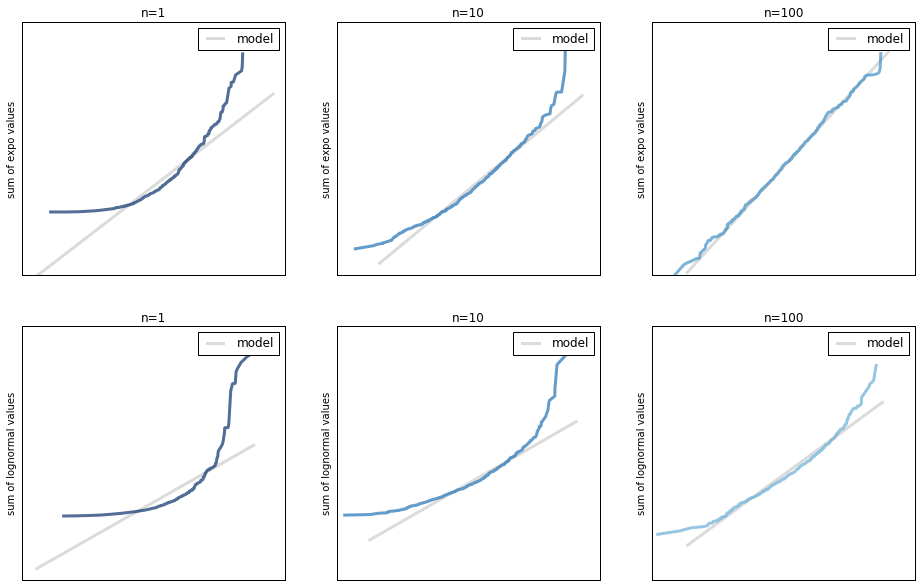

In [4]:
import random
import scipy.stats

def NormalPlotSamples(samples, plot=1, ylabel=''):
    """Makes normal probability plots for samples.

    samples: list of samples
    label: string
    """
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)

        thinkplot.Config(title='n=%d' % n,
                         legend=False,
                         xticks=[],
                         yticks=[],
                         ylabel=ylabel)
        plot += 1


def MakeExpoSamples(beta=2.0, iters=1000):
    """Generates samples from an exponential distribution.

    beta: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples


def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples


def MakeParetoSamples(alpha=1.0, iters=1000):
    """Generates samples from a Pareto distribution.

    alpha: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []

    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

def GenerateCorrelated(rho, n):
    """Generates a sequence of correlated values from a standard normal dist.
    
    rho: coefficient of correlation
    n: length of sequence

    returns: iterator
    """
    x = random.gauss(0, 1)
    yield x

    sigma = math.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = random.gauss(x * rho, sigma)
        yield x


def GenerateExpoCorrelated(rho, n):
    """Generates a sequence of correlated values from an exponential dist.

    rho: coefficient of correlation
    n: length of sequence

    returns: NumPy array
    """
    normal = list(GenerateCorrelated(rho, n))
    uniform = scipy.stats.norm.cdf(normal)
    expo = scipy.stats.expon.ppf(uniform)
    return expo


def MakeCorrelatedSamples(rho=0.9, iters=1000):
    """Generates samples from a correlated exponential distribution.

    rho: correlation
    iters: number of samples to generate for each size

    returns: list of samples
    """    
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(GenerateExpoCorrelated(rho, n))
                  for _ in range(iters)]
        samples.append((n, sample))
    return samples

def MakeCltPlots1():
    """Makes plot showing distributions of sums converging to normal.
    """
    thinkplot.PrePlot(num=3, rows=2, cols=3)
    samples = MakeExpoSamples()
    NormalPlotSamples(samples, plot=1, ylabel='sum of expo values')

    thinkplot.PrePlot(num=3)
    samples = MakeLognormalSamples()
    NormalPlotSamples(samples, plot=4, ylabel='sum of lognormal values')
    #thinkplot.Config(root='normal1', legend=False)

def MakeCltPlots2():
    thinkplot.PrePlot(num=3, rows=2, cols=3)
    samples = MakeParetoSamples()
    NormalPlotSamples(samples, plot=1, ylabel='sum of Pareto values')

    thinkplot.PrePlot(num=3)
    samples = MakeCorrelatedSamples()
    NormalPlotSamples(samples, plot=4, ylabel='sum of correlated expo values')
    #thinkplot.Config(root='normal2', legend=False)
MakeCltPlots1()

第一行：当n=1时，总和仍然符合指数分布，因此绘制出的正态概率图不是一条直线。当n=10时，总和大致符合正态分布。当n=100时，结果已经与正态分布没有区别了。

第二行：对数分布通常比指数分布偏度大，因此总和分布的收敛速度较慢。当n=10时，图中的正态概率图完全不像直线，当n=100时结果就大致符合正态分布了。

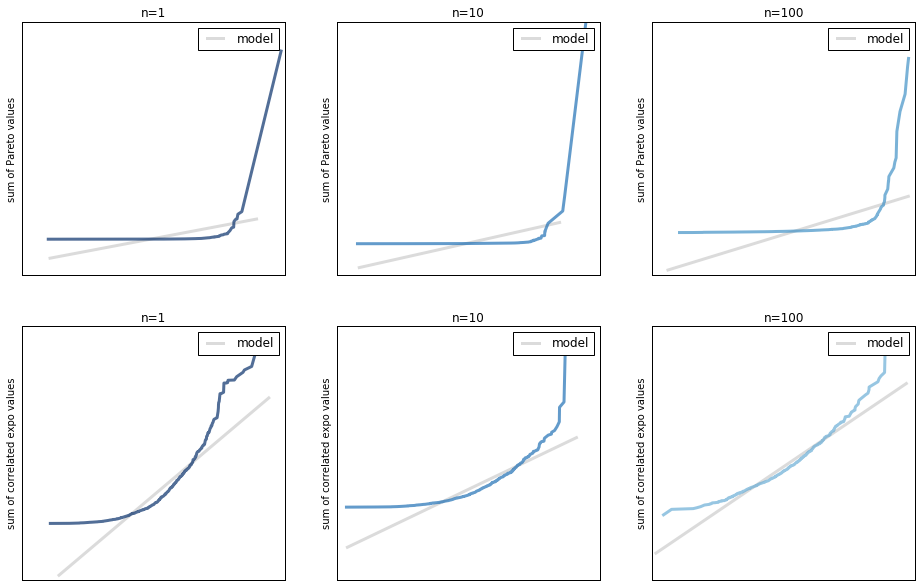

In [5]:
MakeCltPlots2()

Pareto分布比对数分布偏度更大。很多Pareto分布的均值和方差不是有限值，因此不能使用中心极限定理。即使n=100时，得到的正态概率图也远非直线。

第二行展示了rho=0.9时，相关指数值的总和分布。取值的相关性使收敛速度变慢，但当n=100时，正态概率图也近似直线。由此可见，虽然严格来说，当取值相关时CLT不适用，但是在实际应用中，中等程度的相关性影响并不大。

In [7]:
def MakeFrames():
    """Reads pregnancy data and partitions first babies and others.

    returns: DataFrames (all live births, first babies, others)
    """
    preg = nsfg.ReadFemPreg()

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert len(live) == 9148
    assert len(firsts) == 4413
    assert len(others) == 4735

    return live, firsts, others

prglngth example
0.0780372667775
null hypothesis N(0, 0.00319708)
0.0837707042554 0.0837707042554


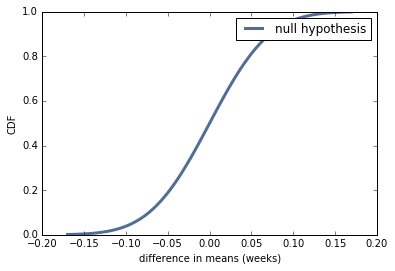

In [8]:
def SamplingDistMean(data, n):
    """Computes the sampling distribution of the mean.

    data: sequence of values representing the population
    n: sample size

    returns: Normal object
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

def PlotPregLengths(live, firsts, others):
    """Plots sampling distribution of difference in means.

    live, firsts, others: DataFrames
    """
    print('prglngth example')
    delta = firsts.prglngth.mean() - others.prglngth.mean()
    print(delta)

    dist1 = SamplingDistMean(live.prglngth, len(firsts))
    dist2 = SamplingDistMean(live.prglngth, len(others))
    dist = dist1 - dist2
    print('null hypothesis', dist)
    print(dist.Prob(-delta), 1 - dist.Prob(delta))

    thinkplot.Plot(dist, label='null hypothesis')
    thinkplot.Config(root='normal3',
                   xlabel='difference in means (weeks)',
                   ylabel='CDF')

live, firsts, others = MakeFrames()
PlotPregLengths(live, firsts, others)

第9章例子：检验第一胎和其他新生儿的妊娠时间均值的明显差异。这个差异约为0.078周。

假设检验：计算一个p值，即在原假设条件下，所观测到差异出现的概率，如果这个值很小，就认为观测到的差异不太可能是偶然产生的。

原假设为：第一胎和其他新生儿的妊娠时间具有相同分布。根据CLT，均值的抽样分布是符合正态分布的。

计算出均值差异的抽样分布：N(0, 0.0032)，计算单侧检验和双侧检验的p值都为0.084，因为正态分布是对称的。尾部的和为0.168与第9章的估计值0.17相符。

## 相关检验
第9章使用置换检验，检验新生儿体重与母亲年龄的相关性，认为这一相关是统计显著的，p值小于0.001。

对于符合正态分布且互不相关的两个变量，生成大小为n的样本，算出Pearson相关系数r，然后计算变换相关性：

$t=r\sqrt{\frac{n-2}{1-r^2}}$

t符合参数为n-2的t分布。

In [11]:
class CorrelationPermute(thinkstats2.HypothesisTest):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

0.0688339703541 2.86146661921e-11


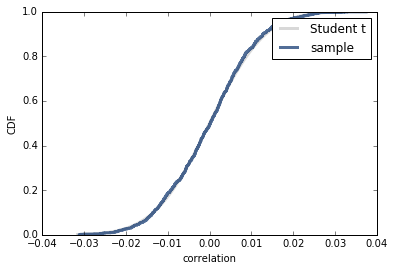

In [12]:
class CorrelationPermute(CorrelationPermute):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        return np.corrcoef(xs, ys)[0][1]

def ResampleCorrelations(live):
    """Tests the correlation between birth weight and mother's age.

    live: DataFrame for live births

    returns: sample size, observed correlation, CDF of resampled correlations
    """
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

def StudentCdf(n):
    """Computes the CDF correlations from uncorrelated variables.

    n: sample size

    returns: Cdf
    """
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    return thinkstats2.Cdf(rs, ps)

def TestCorrelation(live):
    """Tests correlation analytically.

    live: DataFrame for live births

    """
    n, r, cdf = ResampleCorrelations(live)

    model = StudentCdf(n)
    thinkplot.Plot(model.xs, model.ps, color='gray',
                   alpha=0.3, label='Student t')
    thinkplot.Cdf(cdf, label='sample')

    thinkplot.Config(root='normal4',
                   xlabel='correlation',
                   ylabel='CDF')

    t = r * math.sqrt((n-2) / (1-r**2))
    p_value = 1 - scipy.stats.t.cdf(t, df=n-2)
    print(r, p_value)
TestCorrelation(live)

上图展示了计算得到的分布以及第9章通过重抽样得到的分布，两者相差无几。虽然实际分布并不是正态分布，但Pearson相关系数是基于样本均值和方差。根据中心极限定理，即使数据不符合正态分布，这些基于时刻(moment-based)的统计量也是符合正态分布的。

可以计算出对应于r=0.07的t值，然后计算在t处的t分布值，为2.86e-11.

## 卡方检验
第9章使用卡方统计量，检验一个骰子是否有问题。卡方统计量度量实际值与预期值的正态化偏差总和。

$\chi^2=\sum_i{\frac{(O_i-E_i)^2}{E_i}}$

卡方统计量在原假设条件下的抽样分布是分析分布，最巧的是1，这个分布就称为卡方分布。

In [14]:
class DiceTest(thinkstats2.HypothesisTest):
    """Tests whether a six-sided die is fair."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: list of frequencies
        """
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = sum(self.data)
        values = [1,2,3,4,5,6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

class DiceChiTest(DiceTest):
    """Tests a six-sided die using a chi-squared statistic."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: list of frequencies
        """
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

11.6 0.040699388504


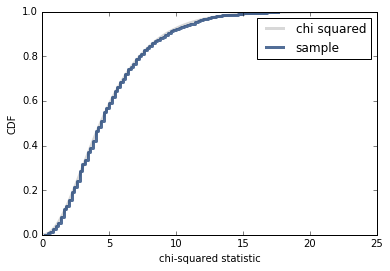

In [15]:
def ChiSquaredCdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size
    
    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n-1)
    return thinkstats2.Cdf(xs, ps)


def TestChiSquared():
    """Performs a chi-squared test analytically.
    """
    data = [8, 9, 19, 5, 8, 11]
    dt = DiceChiTest(data)
    p_value = dt.PValue(iters=1000)
    n, chi2, cdf = len(data), dt.actual, dt.test_cdf

    model = ChiSquaredCdf(n)
    thinkplot.Plot(model.xs, model.ps, color='gray',
                   alpha=0.3, label='chi squared')
    thinkplot.Cdf(cdf, label='sample')

    thinkplot.Config(root='normal5',
                   xlabel='chi-squared statistic',
                   ylabel='CDF',
                   loc='lower right')

    # compute the p-value
    p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n-1)
    print(chi2, p_value)
TestChiSquared()

图中展示了分析方法得到的结果以及通过重抽样得到的分布，二者非常近似。可以使用这个分布，计算观测到的检验统计量$\chi^2$的p值。得到结果为0.041，与第9章一致。卡方分布的参数也是“自由度”。在这里，正确的参数为n-1，其中n为投掷结果概率表的大小：6。